In [1]:
import os
os.chdir("/workspace/")
from glob import glob
from typing import List
import matplotlib.pyplot as plt

import cv2
import imgaug.augmenters as iaa
import numpy as np
import torch
from einops import rearrange
from torch.utils.data import Dataset
from torchvision import transforms

from data import rand_perlin_2d_np

![nn](assets/anomaly_synthesis.png)

### Load Original Image

In [10]:
#original_struct_img = cv2.imread("dataset/mvtec_ad/capsule/train/good/000.png")
original_struct_img = cv2.imread("dataset/mvtec_ad/capsule/train/good/004.png")
#original_struct_img = cv2.imread("dataset/VisA/macaroni1/Data/Images/Normal/0001.JPG")
original_struct_img = cv2.cvtColor(original_struct_img, cv2.COLOR_BGR2RGB)

original_texture_img = cv2.imread("dataset/mvtec_ad/leather/train/good/000.png")
original_texture_img = cv2.cvtColor(original_texture_img, cv2.COLOR_BGR2RGB)
#resize
original_struct_img = cv2.resize(original_struct_img, (256, 256))
original_texture_img = cv2.resize(original_texture_img, (256, 256))

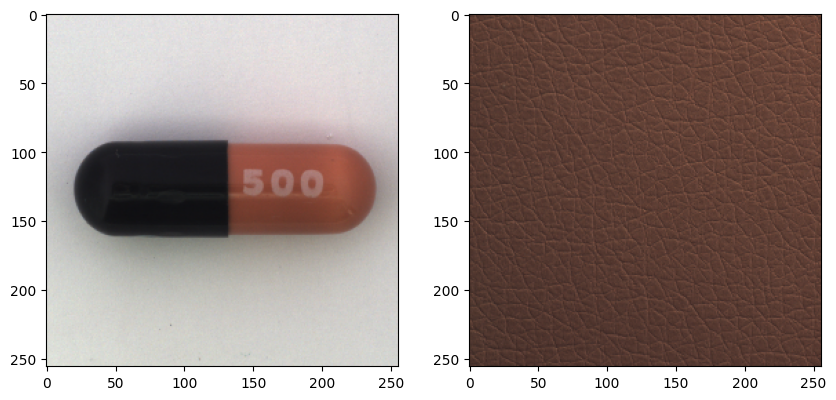

In [11]:
fig, ax = plt.subplots(1,2, figsize=(10,15))
ax[0].imshow(original_struct_img)
ax[1].imshow(original_texture_img)
plt.show()

### make forward mask

In [29]:
def generate_target_foreground_mask(img: np.ndarray) -> np.ndarray:
    # convert RGB into GRAY scale
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # generate binary mask of gray scale image
    _, target_background_mask = cv2.threshold(
        img_gray, 100, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU
    )
    target_background_mask = target_background_mask.astype(np.int_)

    # invert mask for foreground mask
    target_foreground_mask = - (target_background_mask - 1)
    # add 255 to all value in target_foregrounmask
    target_foreground_mask = target_foreground_mask + 254

    return target_foreground_mask#target_foreground_mask

def crop_and_resize_random_quarter(image: np.ndarray) -> np.ndarray:
    # Get the dimensions of the input image
    height, width = image.shape[:2]

    # Calculate the quarter size
    quarter_height = height // 2
    quarter_width = width // 2

    # Generate random starting coordinates for cropping
    start_y = np.random.randint(0, height - quarter_height)
    start_x = np.random.randint(0, width - quarter_width)

    # Crop and resize the random quarter of the image
    cropped_quarter = image[
        start_y : start_y + quarter_height, start_x : start_x + quarter_width
    ]
    resized_quarter = cv2.resize(cropped_quarter, (width, height))

    return resized_quarter
struct_img_foreground_mask = generate_target_foreground_mask(original_struct_img)
#if textual 
texture_img_foreground_mask = generate_target_foreground_mask(crop_and_resize_random_quarter(original_texture_img))


Text(0.5, 1.0, 'texture_img_foreground_mask')

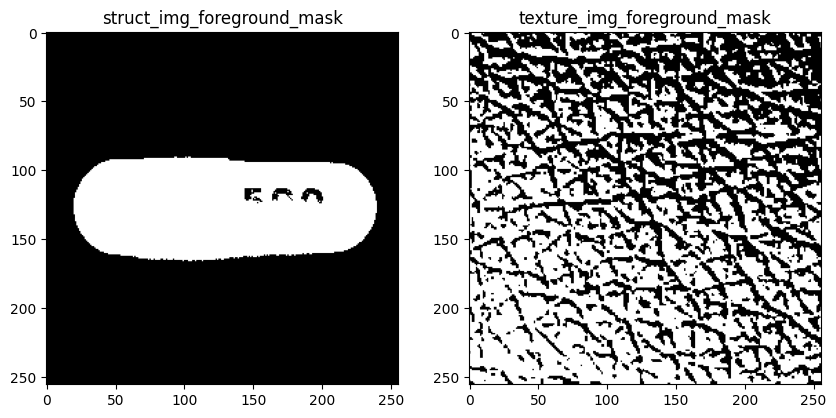

In [30]:
fig, ax = plt.subplots(1,2, figsize=(10,15))
ax[0].imshow(struct_img_foreground_mask, cmap='gray')
ax[0].set_title("struct_img_foreground_mask")
ax[1].imshow(texture_img_foreground_mask, cmap='gray')
ax[1].set_title("texture_img_foreground_mask")

### make perlin noise

In [31]:
img_size = (256, 256)
perlin_scale = 6
min_perlin_scale = 0
perlin_noise_threshold = 0.5
perlin_scale_range = [2**i for i in range(min_perlin_scale, perlin_scale)]
# make perlin noise
def generate_perlin_noise_mask() -> np.ndarray:
    # define perlin noise scale
    perlin_scalex = perlin_scaley = np.random.choice(perlin_scale_range)

    # generate perlin noise
    perlin_noise = rand_perlin_2d_np(
        (img_size[0], img_size[1]), (perlin_scalex, perlin_scaley)
    )

    # apply affine transform
    rot = iaa.Affine(rotate=(-90, 90))
    perlin_noise = rot(image=perlin_noise)

    # make a mask by applying threshold
    mask_noise = np.where(
        perlin_noise > perlin_noise_threshold,
        np.ones_like(perlin_noise),
        np.zeros_like(perlin_noise),
    )

    return mask_noise

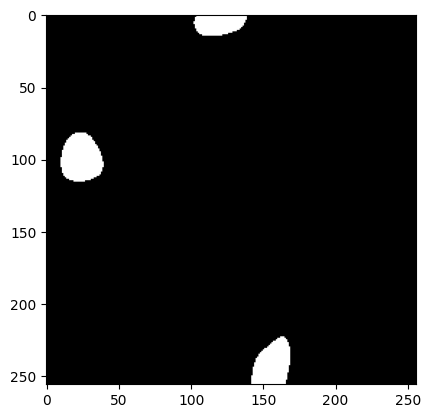

In [32]:
perlin_noise_mask = generate_perlin_noise_mask()
plt.imshow(perlin_noise_mask, cmap='gray')
plt.show()

### mask generation

In [33]:
struct_mask = perlin_noise_mask * struct_img_foreground_mask
struct_mask_inversed = 1 - struct_mask

texture_mask = perlin_noise_mask * texture_img_foreground_mask
texture_mask_inversed = 1 - texture_mask

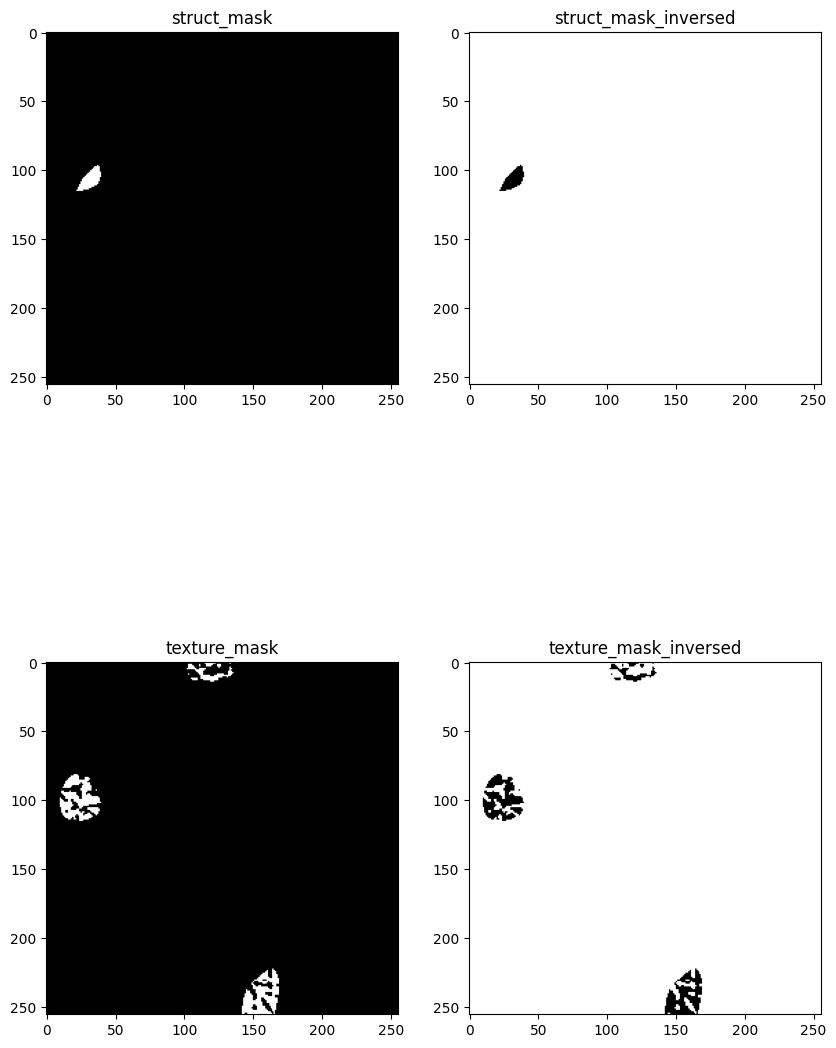

In [34]:
fig, ax = plt.subplots(2,2, figsize=(10,15))
ax[0,0].imshow(struct_mask, cmap='gray')
ax[0,0].set_title("struct_mask")
ax[0,1].imshow(struct_mask_inversed, cmap='gray')
ax[0,1].set_title("struct_mask_inversed")
ax[1,0].imshow(texture_mask, cmap='gray')
ax[1,0].set_title("texture_mask")
ax[1,1].imshow(texture_mask_inversed, cmap='gray')
ax[1,1].set_title("texture_mask_inversed")
plt.show()

In [35]:
struct_mask[120]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

### Self Augmentation / DTD dataset Augmentation

In [36]:
# Self-augmentation
grid_size = 8

def randAugmenter() -> iaa.Sequential:
    augmenters = [
        iaa.GammaContrast((0.5, 2.0), per_channel=True),
        iaa.pillike.EnhanceSharpness(),
        iaa.Solarize(0.5, threshold=(32, 128)),
        iaa.Posterize(),
        iaa.Invert(),
        iaa.pillike.Autocontrast(),
        iaa.pillike.Equalize(),
    ]
    aug_ind = np.random.choice(np.arange(len(augmenters)), 2, replace=False)
    aug = iaa.Sequential(
        [
            augmenters[aug_ind[0]],
            augmenters[aug_ind[1]],
        ]
    )
    return aug


def random_arrange(img: np.ndarray) -> np.ndarray:
    assert (
        img_size[0] % grid_size == 0
    ), "structure should be devided by grid size accurately"
    grid_w = img_size[1] // grid_size
    grid_h = img_size[0] // grid_size

    source_img = rearrange(
        tensor=img,
        pattern="(h gh) (w gw) c -> (h w) gw gh c",
        gw=grid_w,
        gh=grid_h,
    )
    disordered_idx = np.arange(source_img.shape[0])
    np.random.shuffle(disordered_idx)

    source_img = rearrange(
        tensor=source_img[disordered_idx],
        pattern="(h w) gw gh c -> (h gh) (w gw) c",
        h=grid_size,
        w=grid_size,
    ).astype(np.uint8)

    return source_img

## dtd dataset
textual_datalist = glob(os.path.join("./dataset/dtd/images","*/*.jpg"))
textual_datapath = np.random.choice(textual_datalist, 1)[0]
dtd_textual_image = cv2.imread(textual_datapath)
dtd_textual_image = cv2.cvtColor(dtd_textual_image, cv2.COLOR_BGR2RGB)
dtd_textual_image = cv2.resize(dtd_textual_image, dsize=img_size)

## self-augmentation
struct_img_self_aug = randAugmenter()(images=original_struct_img)
struct_img_self_aug_randarr = random_arrange(struct_img_self_aug)
texture_img_self_aug = randAugmenter()(images=original_texture_img)
texture_img_self_aug_randarr = random_arrange(texture_img_self_aug)

## dtd-augmentation
dtd_textual_image_aug = randAugmenter()(images=dtd_textual_image)
dtd_textual_image_aug_randarr = random_arrange(dtd_textual_image_aug)


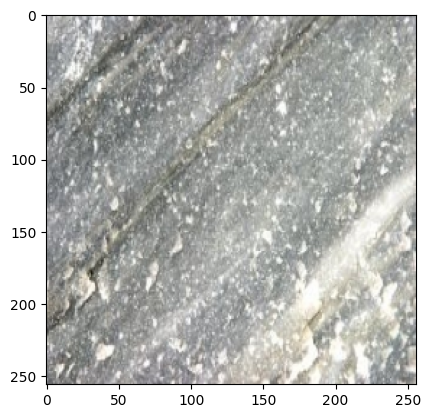

In [37]:
plt.imshow(dtd_textual_image)

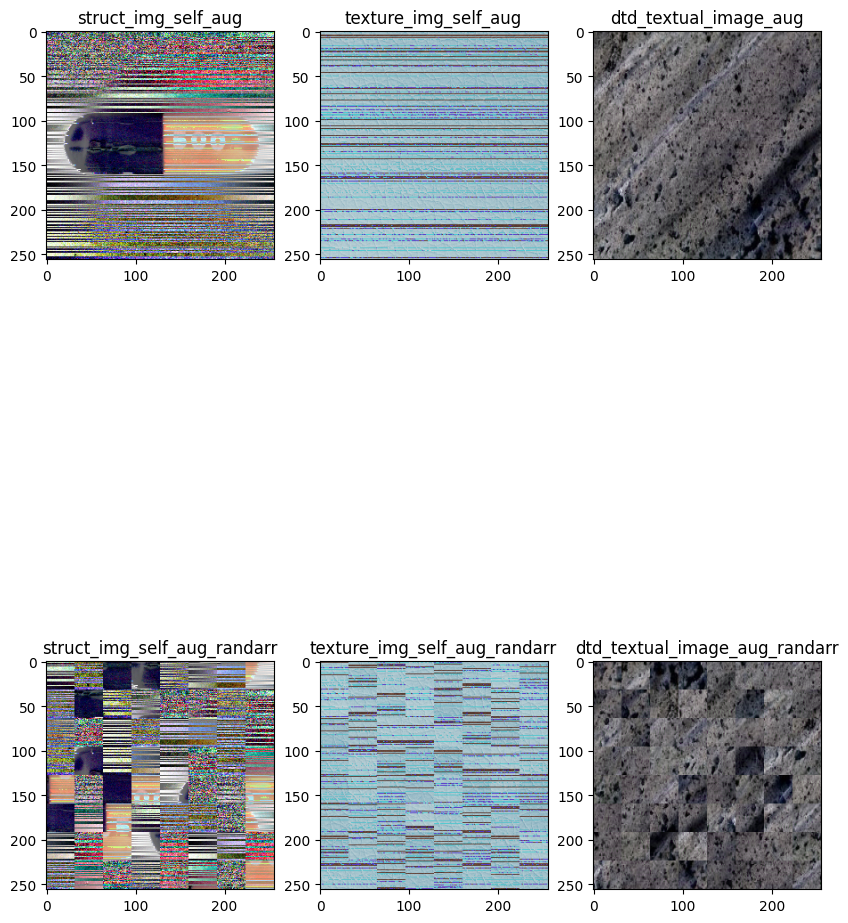

In [38]:
fig, ax = plt.subplots(2,3, figsize=(10,15))
ax[0,0].imshow(struct_img_self_aug)
ax[0,0].set_title("struct_img_self_aug")
ax[0,1].imshow(texture_img_self_aug)
ax[0,1].set_title("texture_img_self_aug")
ax[0,2].imshow(dtd_textual_image_aug)
ax[0,2].set_title("dtd_textual_image_aug")
ax[1,0].imshow(struct_img_self_aug_randarr)
ax[1,0].set_title("struct_img_self_aug_randarr")
ax[1,1].imshow(texture_img_self_aug_randarr)
ax[1,1].set_title("texture_img_self_aug_randarr")
ax[1,2].imshow(dtd_textual_image_aug_randarr)
ax[1,2].set_title("dtd_textual_image_aug_randarr")
plt.show()

### Blend Image

In [39]:
transparency_range = [0.15, 1.0]
factor = np.random.uniform(*transparency_range, size=1)[0]

In [40]:
struct_mask_reshaped = np.repeat(struct_mask[:, :, np.newaxis], 3, axis=2)
struct_mask_inversed_reshaped = np.repeat(struct_mask_inversed[:, :, np.newaxis], 3, axis=2)

texture_mask_reshaped = np.repeat(texture_mask[:, :, np.newaxis], 3, axis=2)
texture_mask_inversed_reshaped = np.repeat(texture_mask_inversed[:, :, np.newaxis], 3, axis=2)

In [41]:
factor

0.2091061339696693

In [42]:
sturct_synthesis_selfaug = factor * (struct_mask_reshaped * original_struct_img) \
    + (1 - factor) * (struct_mask_reshaped * struct_img_self_aug_randarr)   \
    + (struct_mask_inversed_reshaped * original_struct_img)
sturct_synthesis_selfaug = sturct_synthesis_selfaug.astype(np.uint8)

stuct_synthesis_dtdaug = factor * (struct_mask_reshaped * original_struct_img) \
    + (1 - factor) * (struct_mask_reshaped * dtd_textual_image_aug_randarr)   \
    + (struct_mask_inversed_reshaped * original_struct_img)
stuct_synthesis_dtdaug = stuct_synthesis_dtdaug.astype(np.uint8)

texture_synthesis_selfaug = factor * (texture_mask_reshaped * original_texture_img) \
    + (1 - factor) * (texture_mask_reshaped * texture_img_self_aug_randarr)   \
    + (texture_mask_inversed_reshaped * original_texture_img)
texture_synthesis_selfaug = texture_synthesis_selfaug.astype(np.uint8)

texture_synthesis_dtdaug = factor * (texture_mask_reshaped * original_texture_img) \
    + (1 - factor) * (texture_mask_reshaped * dtd_textual_image_aug_randarr)   \
    + (texture_mask_inversed_reshaped * original_texture_img)
texture_synthesis_dtdaug = texture_synthesis_dtdaug.astype(np.uint8)


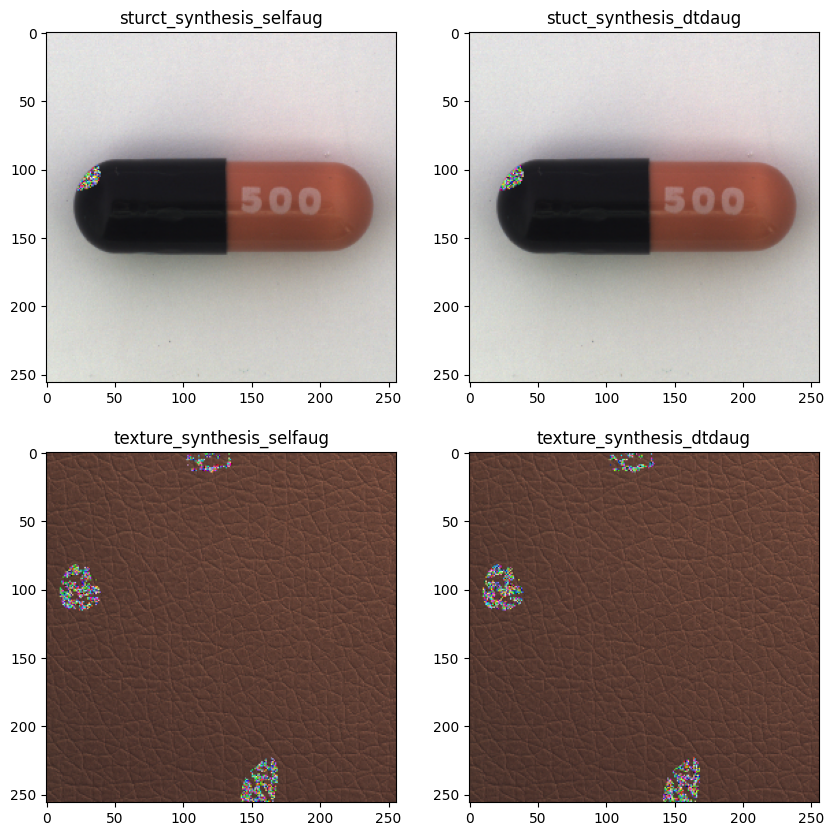

In [43]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].imshow(sturct_synthesis_selfaug)
ax[0,0].set_title("sturct_synthesis_selfaug")
ax[0,1].imshow(stuct_synthesis_dtdaug)
ax[0,1].set_title("stuct_synthesis_dtdaug")
ax[1,0].imshow(texture_synthesis_selfaug)
ax[1,0].set_title("texture_synthesis_selfaug")
ax[1,1].imshow(texture_synthesis_dtdaug)
ax[1,1].set_title("texture_synthesis_dtdaug")
plt.show()